<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/bayesian-model-averaging-method/BMA_basedon_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from functools import partial
import tqdm
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
import sklearn
import sklearn.preprocessing

In [186]:
!pip install blitz-bayesian-pytorch
import blitz
import blitz.modules
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**BNN代理模型构建**

In [187]:
def generating_sample(func, var_inforamtion, num_train, num_test):

  num = num_train + num_test
  num = int(num)
  # sampling for inputs
  ins = np.zeros(shape = [num, 1])
  var_num = len(var_inforamtion)
  for i in range(var_num):
    distribution_infromation = var_inforamtion[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
  ins = np.delete(ins, 0, axis = 1)
  # calculating for response
  labs = func(ins)
  
  ins = sklearn.preprocessing.StandardScaler().fit_transform(ins)
  labs = sklearn.preprocessing.StandardScaler().fit_transform(labs.reshape(-1,1))
  # transformation from numpy.array to torch.tensor
  
  ins = torch.from_numpy(ins).float()
  labs = torch.from_numpy(labs).float()
  
  # split to train_set and test_set
  train_volume = int(num_train)
  data_index = list(range(num))
  
  train_index = random.sample(range(0, num), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_ins, train_labs = ins[train_index, :], labs[train_index, :]
  test_ins, test_labs = ins[test_index, :], labs[test_index, :]

  # packaging by DataLoader and TensorDataset
  train_set = TensorDataset(train_ins, train_labs)
  train_set = DataLoader(train_set, batch_size = train_volume)
  
  test_set = TensorDataset(test_ins, test_labs)
  test_set = DataLoader(test_set, batch_size = train_volume)

  return train_set, test_set

In [188]:
@variational_estimator
class BayesianLinearRegression(nn.Module):

  def __init__(self, in_features, out_features):
    super().__init__()

    self.fc_1 = nn.Linear(in_features, in_features * 50)
    self.fc_2 = nn.Linear(in_features * 50, in_features * 100)
    self.fc_3 = nn.Linear(in_features * 100, in_features * 50)
    self.fc_4 = BayesianLinear(in_features * 50, in_features * 20)
    self.fc_5 = BayesianLinear(in_features * 20, out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    x = self.relu(self.fc_4(x))
    y = self.fc_5(x)
    
    return y

In [189]:
def evaluate(model, test_set, num_samples, std_multiplier, iterior):

  for index, (x_test, y_test) in enumerate(test_set):
    
    preds = [model(x_test) for i in range(num_samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    
    ic_acc = (ci_lower <= y_test) * (ci_upper >= y_test)
    ic_acc = ic_acc.float().mean()

    plt.figure(iterior, figsize=(10, 8), dpi=80)
    count = list(range(means.shape[0]))
    plt.scatter(count, y_test, color = 'black')
    plt.plot(count, means.detach().numpy(), color = 'blue')
    
    plt.fill_between(count, ci_lower.squeeze().detach().numpy(), ci_upper.squeeze().detach().numpy(), alpha = 0.4, color = 'blue')
    
    plt.title(f'the error bar of the mdoel trained {iterior}th in test set ')
    plt.xlabel('Index of test data')
    plt.ylabel('Response')
    plt.show()
    print(f"the accuracy in test set is {ic_acc}")
  
  return means, stds

In [190]:
def training_precess(model, train_set, test_set, train_epoch):

  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  #criterion = torch.nn.SmoothL1Loss()
  criterion = torch.nn.MSELoss()
  loss_hist = []
  for epoch in trange(train_epoch):
    for index, (x_train, y_train) in enumerate(train_set):
      optimizer.zero_grad()
      loss = model.sample_elbo(inputs = x_train, labels = y_train, criterion = criterion, sample_nbr = 3, complexity_cost_weight = 1 / x_train.shape[0])
      loss_hist.append(loss.item())
      
      loss.backward()
      optimizer.step()
    
    if epoch % 500 == 0:
      evaluate(model, test_set, num_samples = 200, std_multiplier = 2, iterior = epoch)
  
  evaluate(model, test_set, num_samples = 100, std_multiplier = 2, iterior = epoch)
  plt.figure(epoch + 1, figsize=(10, 8), dpi=80)
  plt.plot(loss_hist)
  
  return model

In [191]:
def posterior_evaluation(func, model, var_information, num_samples):
  # sampling
  num = int(num_samples)
  ins = np.zeros(shape = [num, 1])
  var_num = len(var_information)
  for i in range(var_num):
    distribution_infromation = var_information[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
  ins = np.delete(ins, 0, axis = 1)

  labs = func(ins)

  ins = sklearn.preprocessing.StandardScaler().fit_transform(ins)
  labs = sklearn.preprocessing.StandardScaler().fit_transform(labs.reshape(-1,1))

  preds = [model(torch.from_numpy(ins).float()) for i in range(200)]
  preds = torch.stack(preds, dim = 0)
  plt.figure(9999999,figsize=(10, 8), dpi=80)
  sns.distplot(labs, hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  sns.distplot(preds.detach().numpy(), hist=True, kde = True, fit_kws={'color':'c', 'label':'model1','linestyle':'-'})
  plt.title('posterior distribution of bnn VS true distribution from the true func')

In [192]:
from bma_demo import Mathematical_examples_1
inf_model1 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'var_2': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_model2 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'var_2': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_model3 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'var_2': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'var_3': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_model4 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'var_2': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'var_3': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
batch_size = 200
trainset_model1, testset_model1 = generating_sample(Mathematical_examples_1.func_1, inf_model1, batch_size, 50)
trainset_model2, testset_model2 = generating_sample(Mathematical_examples_1.func_2, inf_model2, batch_size, 50)
trainset_model3, testset_model3 = generating_sample(Mathematical_examples_1.func_3, inf_model3, batch_size, 50)
trainset_model4, testset_model4 = generating_sample(Mathematical_examples_1.func_4, inf_model4, batch_size, 50)
for i, (x, y) in enumerate(trainset_model1):
  print(f'ins shape of train data{x.shape}')
  print(f'labs shape of train data{y.shape}')

ins shape of train datatorch.Size([200, 3])
labs shape of train datatorch.Size([200, 1])


  0%|          | 0/2500 [00:00<?, ?it/s]

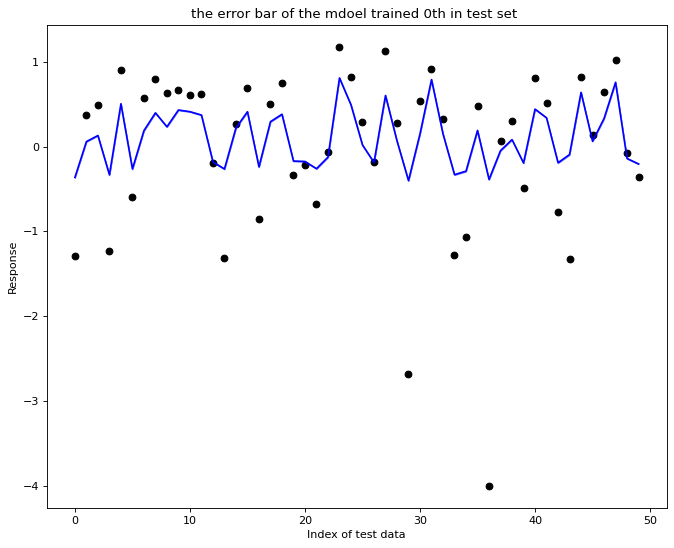

the accuracy in test set is 0.0


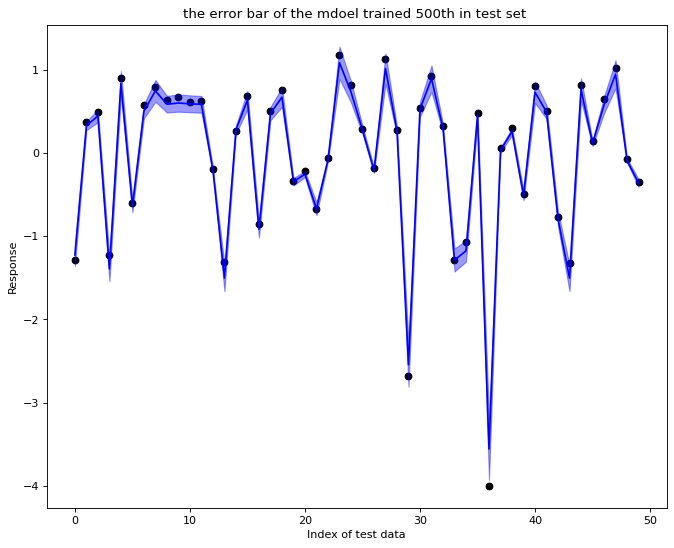

the accuracy in test set is 0.8799999952316284


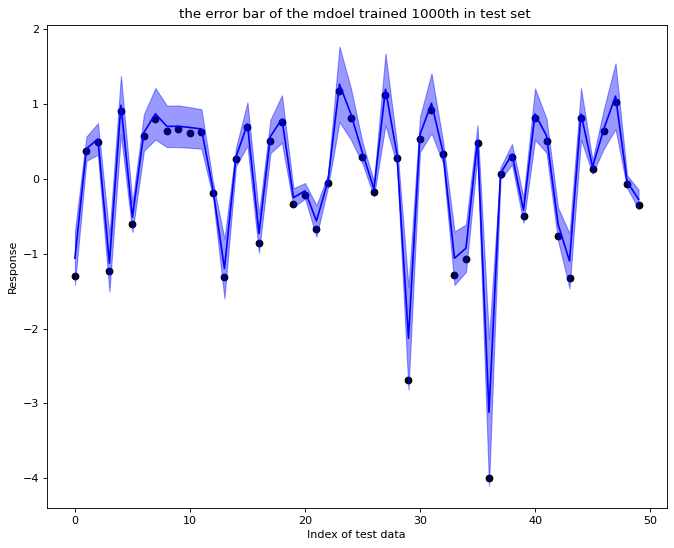

the accuracy in test set is 1.0


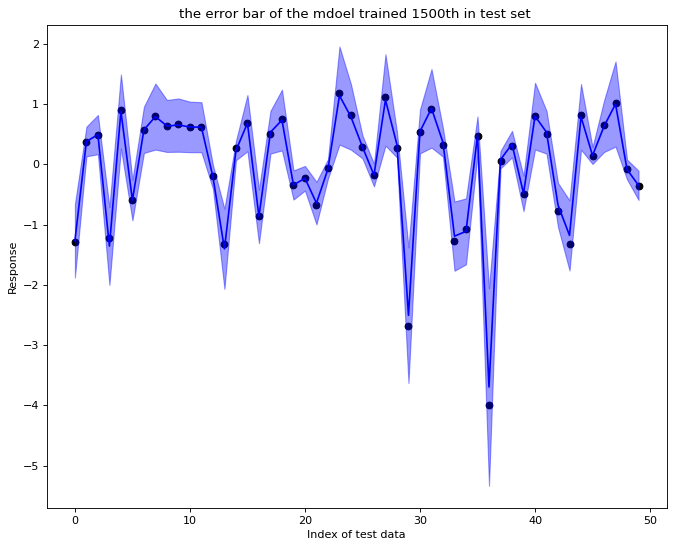

the accuracy in test set is 1.0


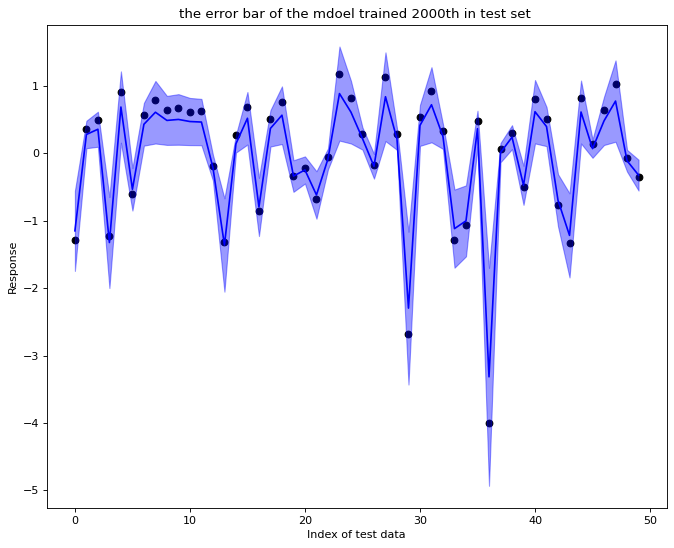

the accuracy in test set is 1.0


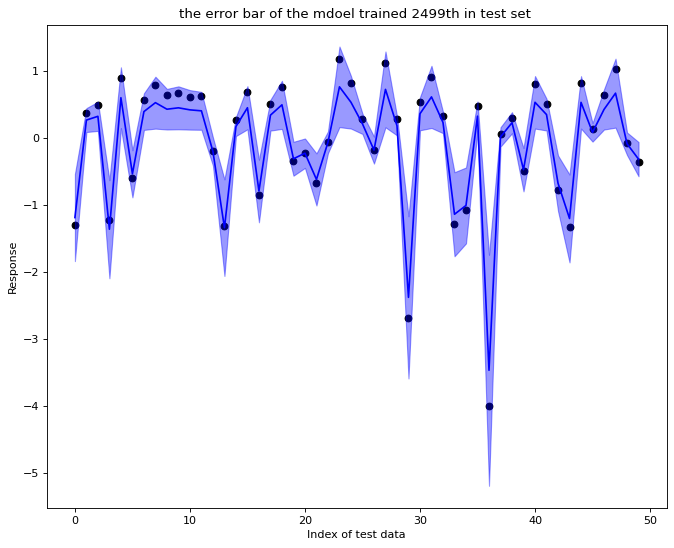

the accuracy in test set is 1.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


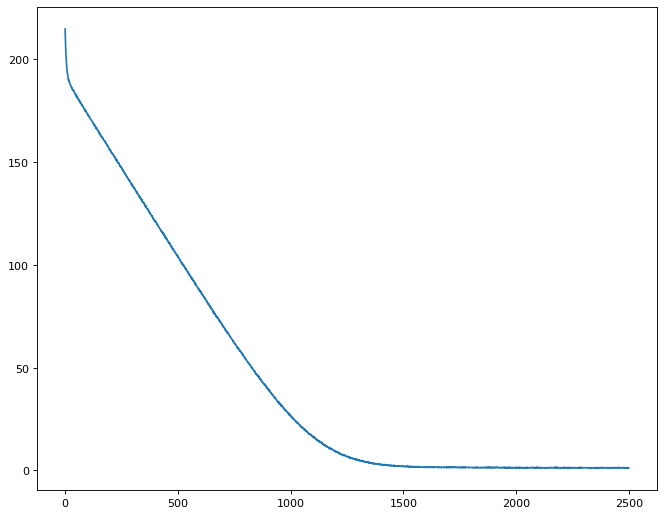

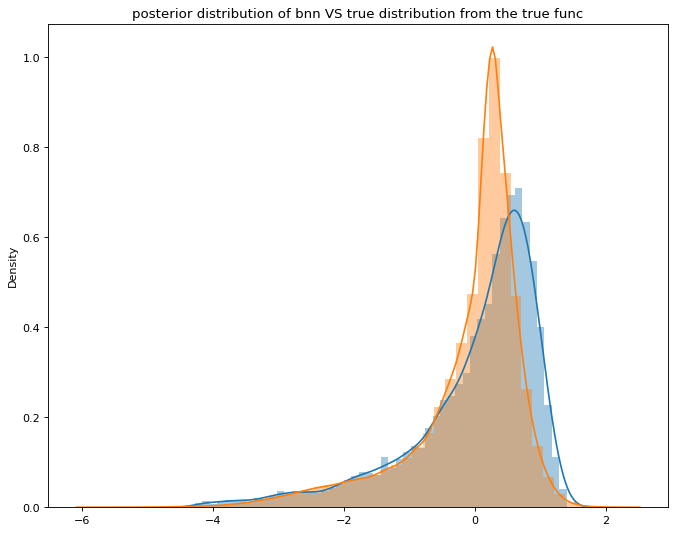

In [193]:
func1 = BayesianLinearRegression(3, 1)
training_precess(func1, trainset_model1, testset_model1, 2500)
posterior_evaluation(Mathematical_examples_1.func_1, func1, inf_model1, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

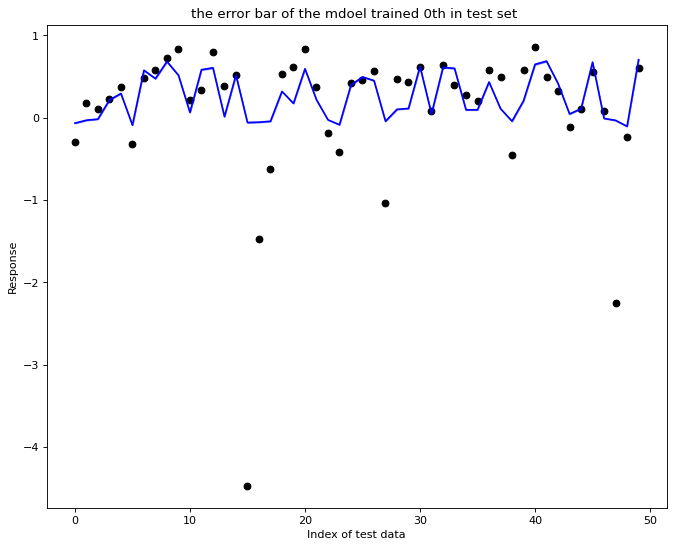

the accuracy in test set is 0.03999999910593033


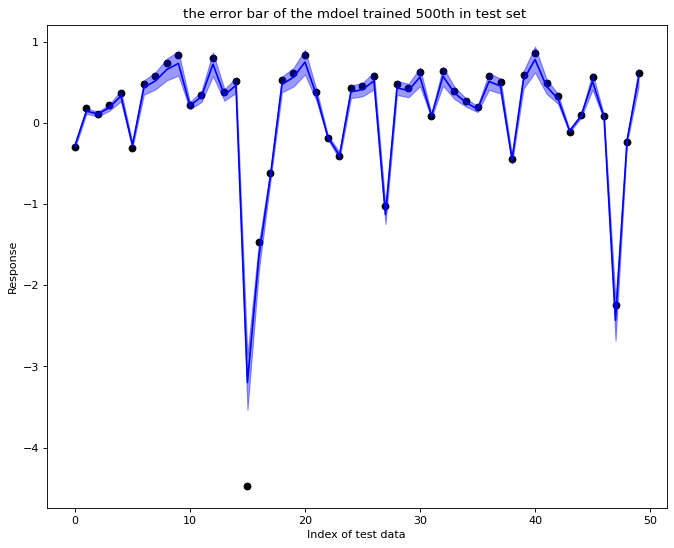

the accuracy in test set is 0.9599999785423279


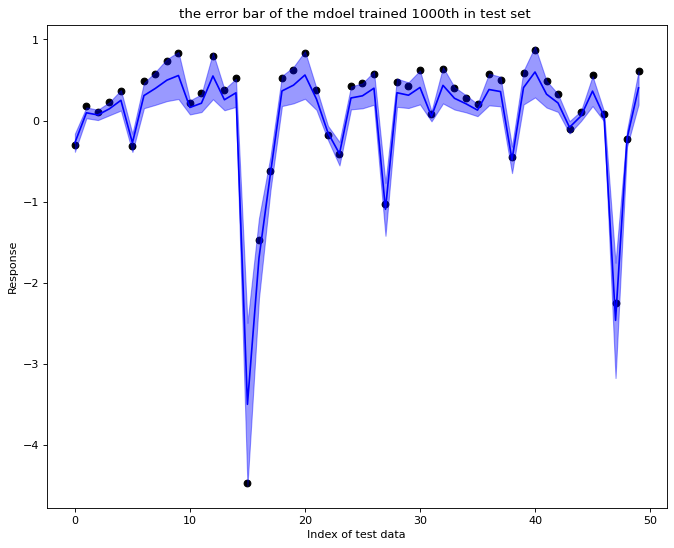

the accuracy in test set is 0.8199999928474426


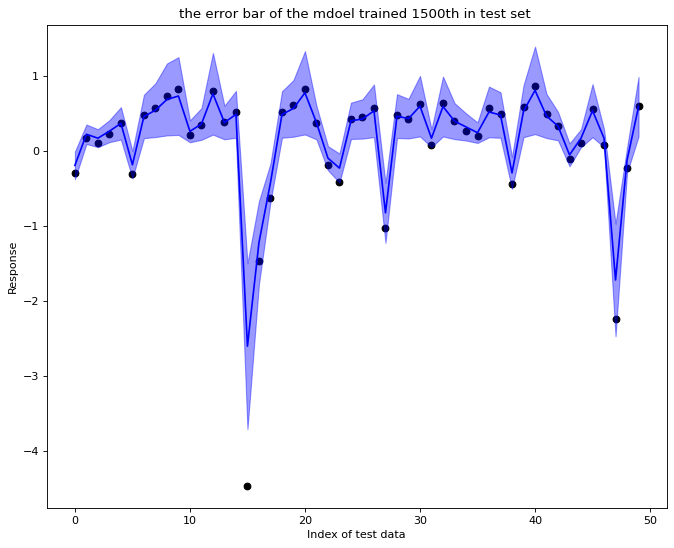

the accuracy in test set is 0.9800000190734863


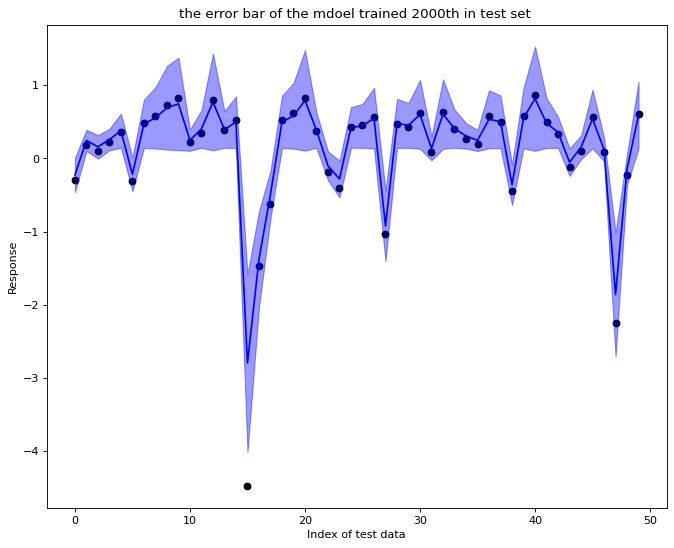

the accuracy in test set is 0.9800000190734863


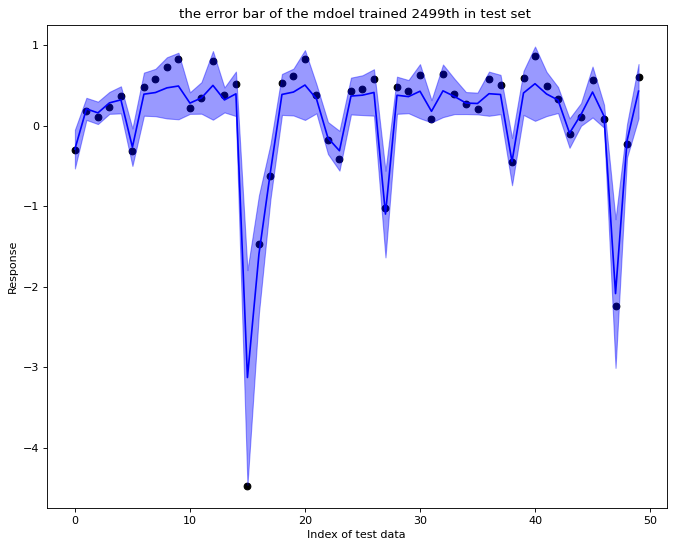

the accuracy in test set is 0.9800000190734863


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


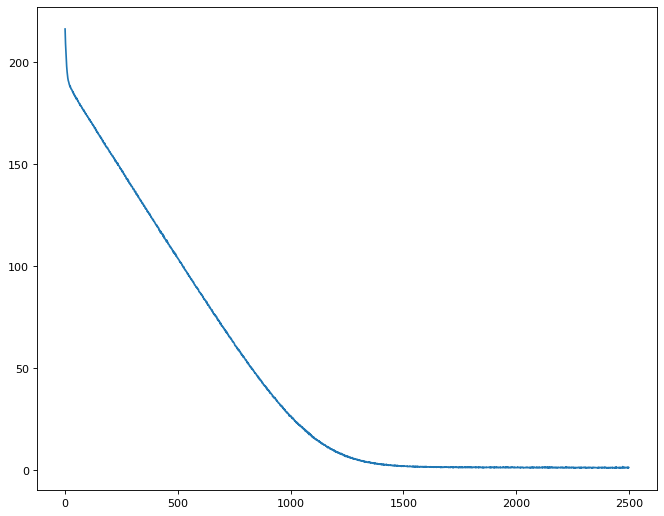

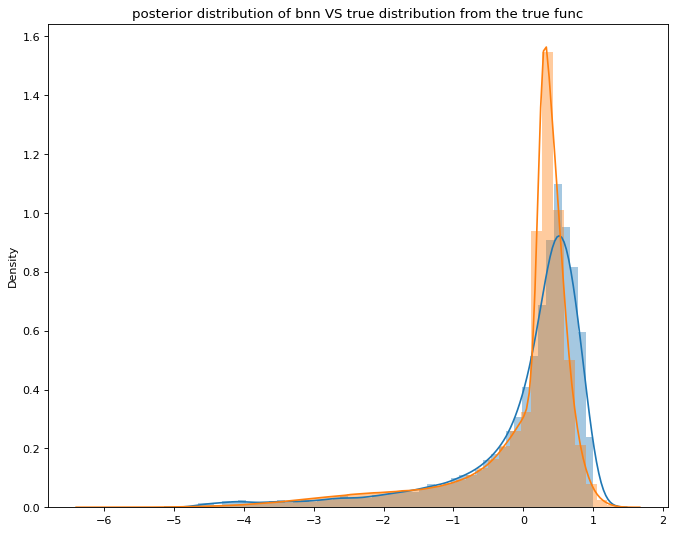

In [194]:
func2 = BayesianLinearRegression(3, 1)
training_precess(func2, trainset_model2, testset_model2, 2500)
posterior_evaluation(Mathematical_examples_1.func_2, func2, inf_model2, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

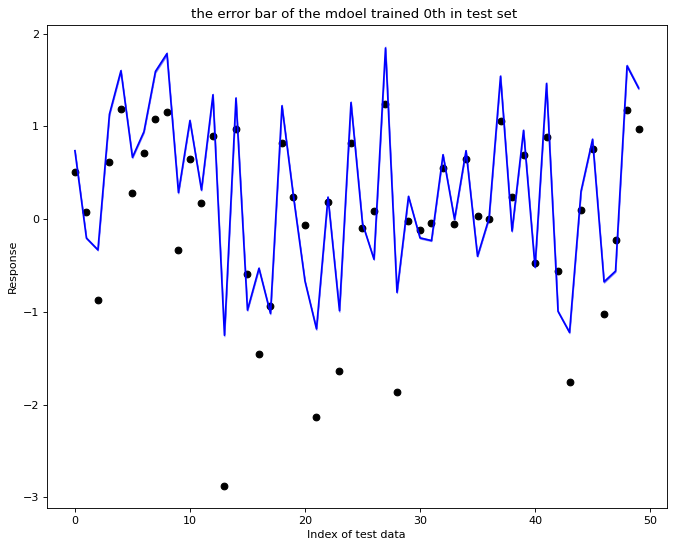

the accuracy in test set is 0.03999999910593033


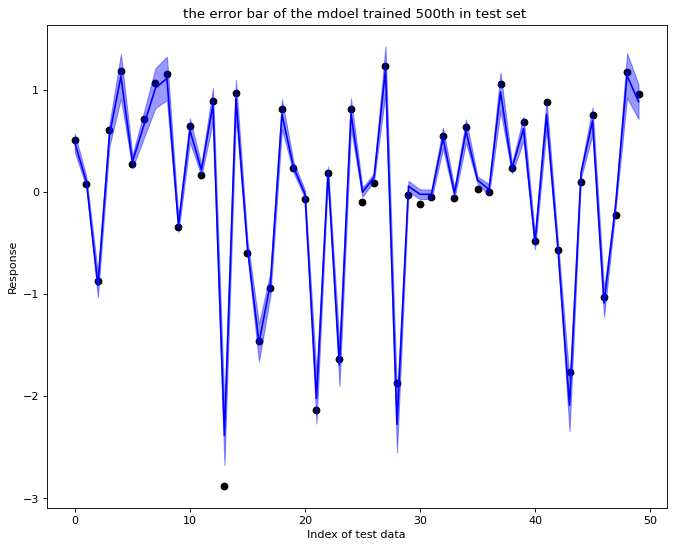

the accuracy in test set is 0.7799999713897705


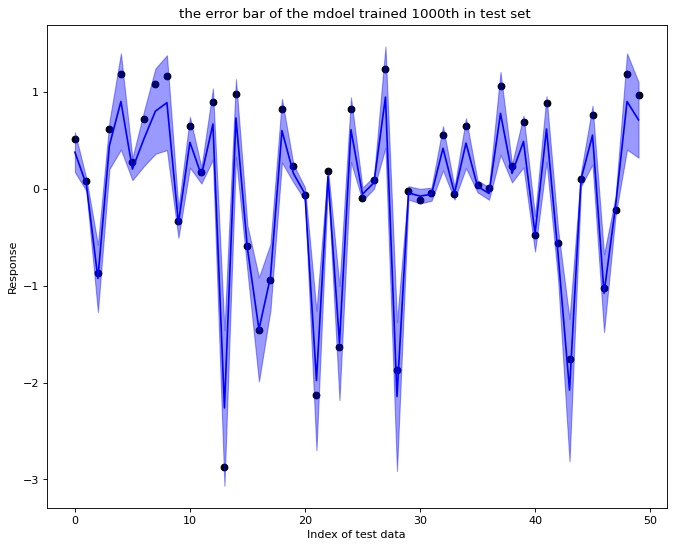

the accuracy in test set is 1.0


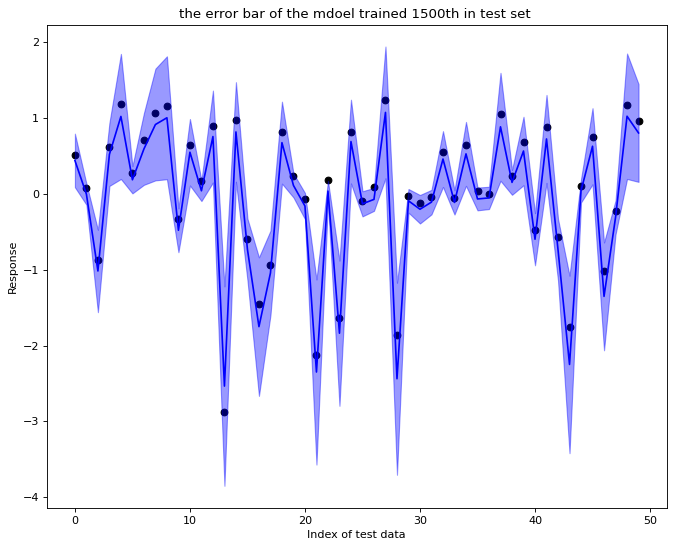

the accuracy in test set is 0.9599999785423279


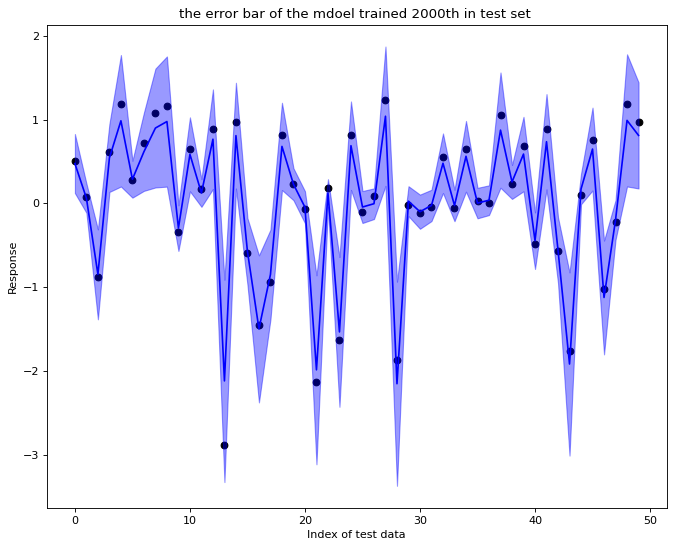

the accuracy in test set is 1.0


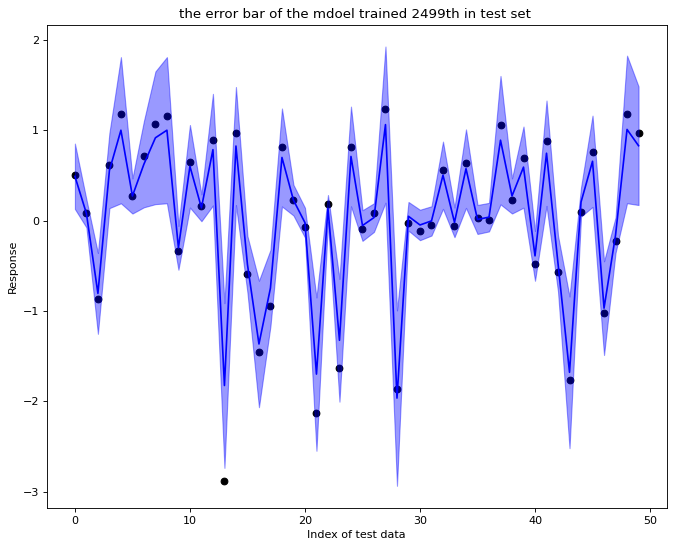

the accuracy in test set is 0.9800000190734863


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


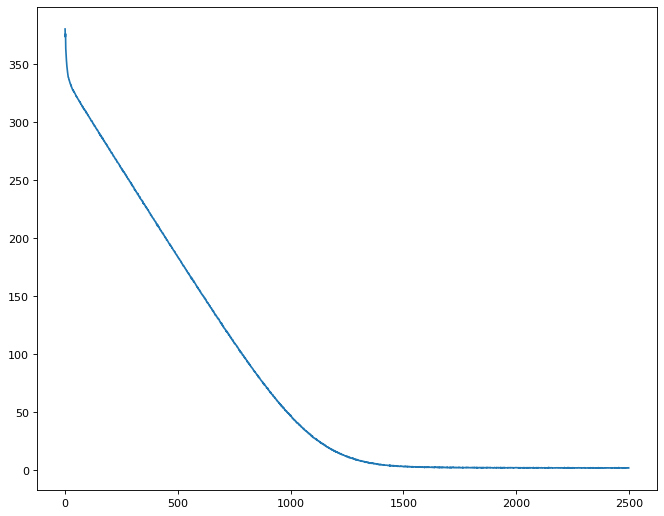

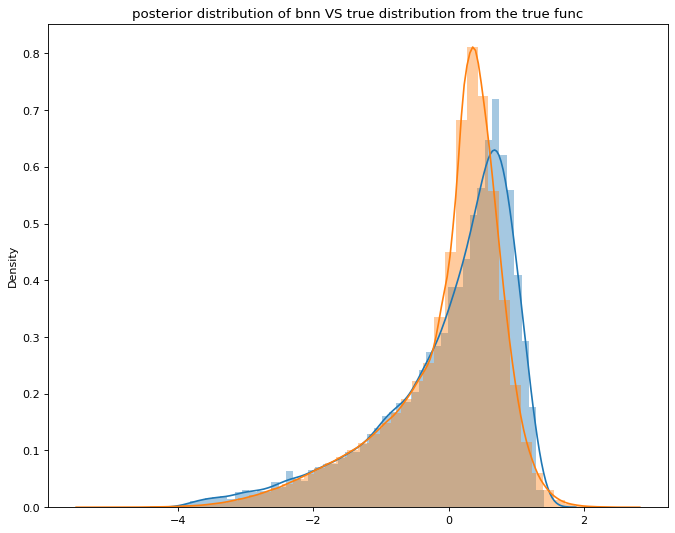

In [195]:
func3 = BayesianLinearRegression(4, 1)
training_precess(func3, trainset_model3, testset_model3, 2500)
posterior_evaluation(Mathematical_examples_1.func_3, func3, inf_model3, 10000)

  0%|          | 0/2500 [00:00<?, ?it/s]

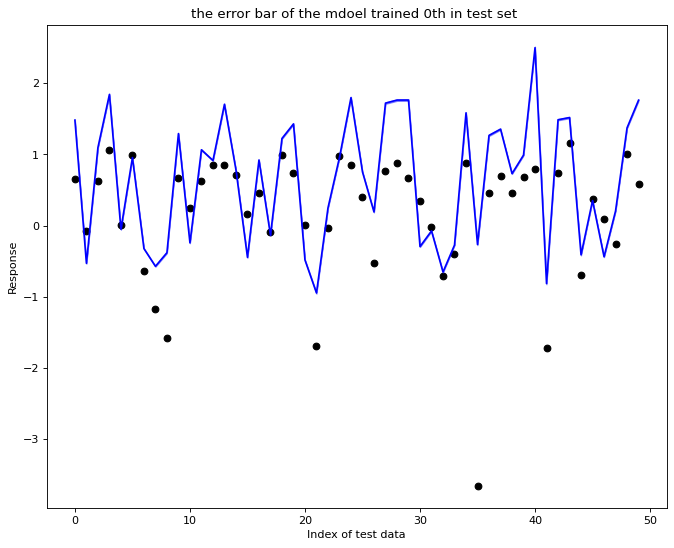

the accuracy in test set is 0.0


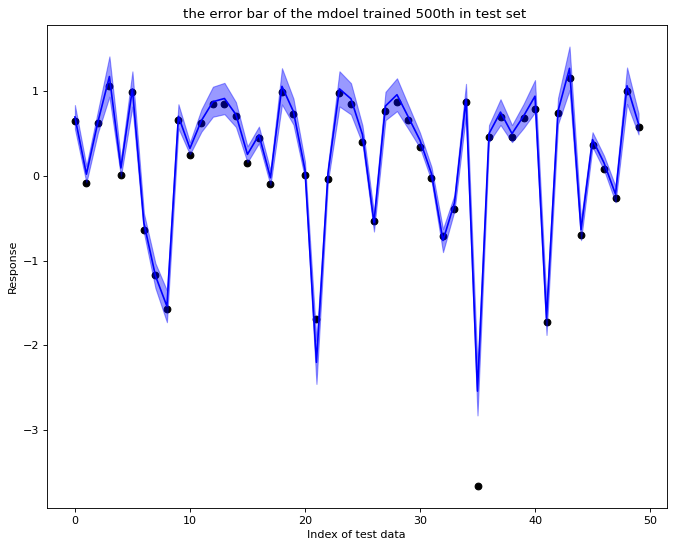

the accuracy in test set is 0.8999999761581421


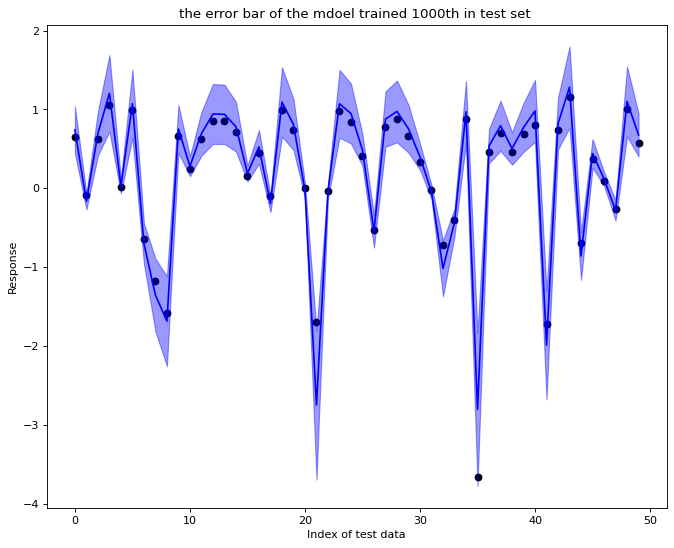

the accuracy in test set is 0.9800000190734863


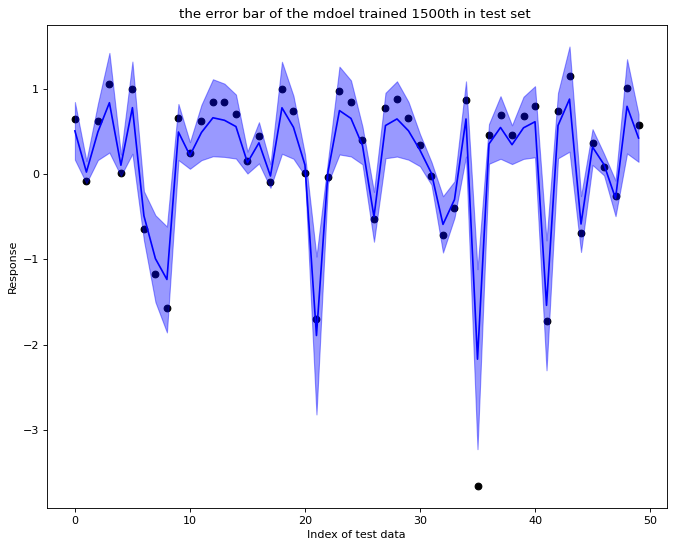

the accuracy in test set is 0.9800000190734863


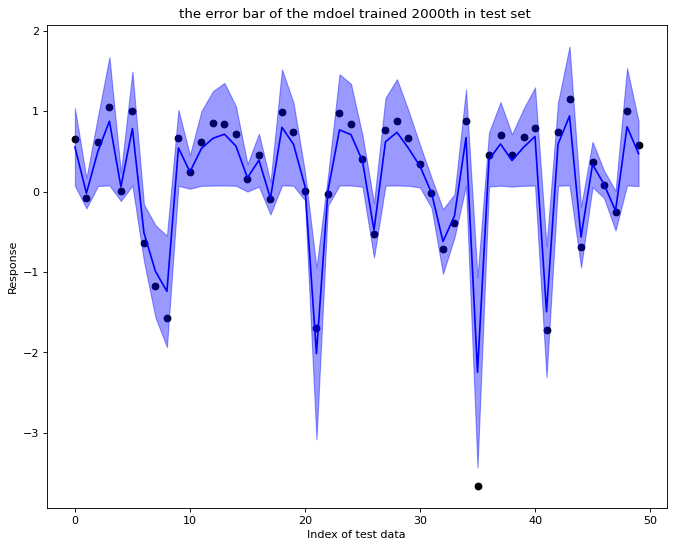

the accuracy in test set is 0.9800000190734863


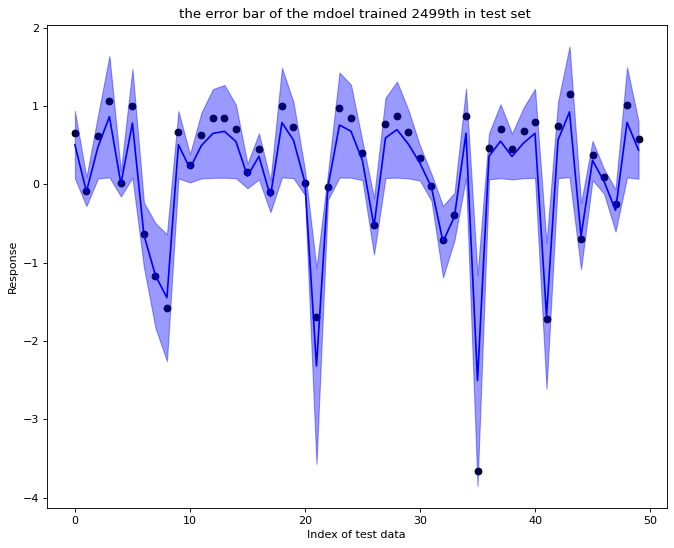

the accuracy in test set is 1.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


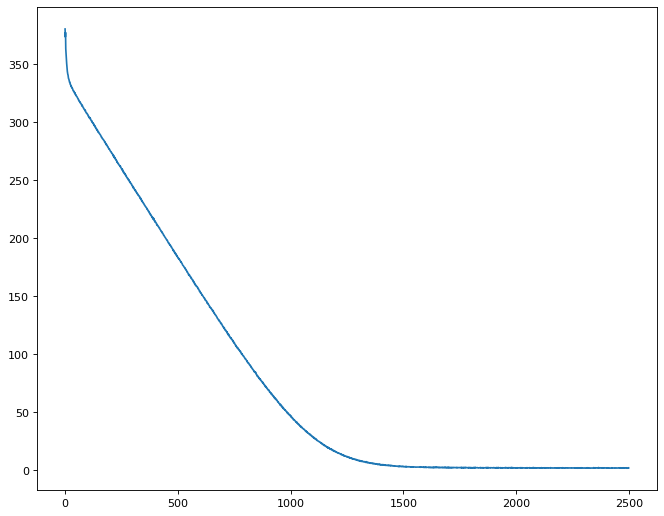

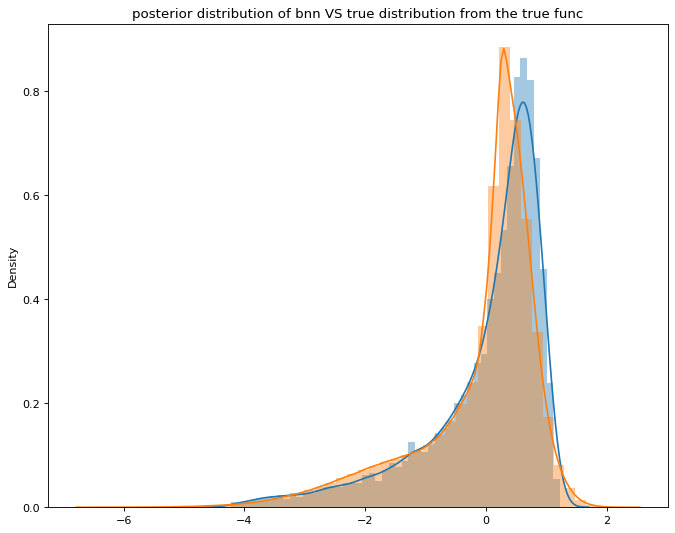

In [196]:
func4 = BayesianLinearRegression(4, 1)
training_precess(func4, trainset_model4, testset_model4, 2500)
posterior_evaluation(Mathematical_examples_1.func_4, func4, inf_model4, 10000)

**BMA模型后验概率估计**

In [197]:
class likelihood_calculation(object):
  # 计算近似似然
  def __init__(self, input_exp, output_exp, theta_information, bnn_model, count_theta, count_weight):
    
    self.input_exp = sklearn.preprocessing.StandardScaler().fit_transform(input_exp)
    self.output_exp = sklearn.preprocessing.StandardScaler().fit_transform(output_exp)
    
    self.theta_information = theta_information
    self.data_volume = input_exp.shape[0]
    self.count_weight = count_weight
    self.count_theta = count_theta
    self.model = bnn_model
  
  def sampling_theta(self):
    
    theta_num = len(self.theta_information)
    theta = np.zeros(shape = [self.count_theta, theta_num])
    thetas = np.zeros(shape = [self.count_theta, self.data_volume, theta_num])
    for i in range(theta_num):
      distribution_infromation = self.theta_information[f'theta_{i}']
      distribution_name = distribution_infromation[0]
      disrtibution_loc = distribution_infromation[1]
      disrtibution_scale = distribution_infromation[2]
      theta_sampling = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [self.count_theta,1])
      theta[:, i] = sklearn.preprocessing.StandardScaler().fit_transform(theta_sampling).squeeze(-1)
    for j in range(self.count_theta):
      thetas[j, :, :] = theta[j, :].reshape(1, -1).repeat(self.data_volume, axis = 0)
    
    return thetas
  
  def predictive(self, inputs):
    
    inputs = inputs.float()
    preds = [self.model(inputs) for i in range(self.count_weight)]
    preds = torch.stack(preds)

    return preds.detach().numpy()


  def sigma2_mle(self, out_model):
    
    out_exp = np.repeat(self.output_exp,self.count_weight, axis = 1)
    
    return np.mean(np.power(out_exp - out_model, 2), axis = 0)
  
  def conditional_marginal_likelihood(self, sigma2):

    return np.power((2 * np.pi * sigma2), -(self.data_volume / 2)) * np.exp(-(self.data_volume / 2))

  
  def marginal_likelihood(self, theta):

    ins = np.concatenate((self.input_exp, theta), axis = 1)


    out_model = self.predictive(torch.from_numpy(ins).float()).squeeze(-1)
    
    sigma = self.sigma2_mle(out_model.T).reshape(-1,1)
    
    store_cl = self.conditional_marginal_likelihood(sigma)
    
    return np.mean(store_cl, axis = 0)
  
  def likelihood(self):
    
    thetas = self.sampling_theta()
    store_l = np.zeros(shape=[self.count_theta, 1])
    
    for i in trange(self.count_theta):
      
      store_l[i, 0] = self.marginal_likelihood(thetas[i, :, :])
    
    return np.sum(store_l, axis = 0) / (self.count_theta)

In [198]:
def posterior_calculation(*args):
  # 根据似然计算结果求解后验概率并绘制饼状图
  num_model = len(args)
  lables = []
  posterior_pro = np.zeros(shape=[num_model])
  normalization_factor = sum(args)
  posterior_list = args / normalization_factor
  for i in range(num_model):
    model_name = f'model_{i+1}'
    lables.append(model_name)
    posterior_pro[i] = posterior_list[i]
  plt.figure(figsize=(10, 8), dpi=80)
  plt.pie(posterior_pro, labels = lables)
  plt.title("Posterior Probability of Model")
  plt.show()
  for j in range(num_model):
    print(f'posterior_pro of {lables[j]} is {posterior_pro[j]}')
  return posterior_pro

In [213]:
def Assessment_of_convergence(input_exp, output_exp, theta_information, model_set, epoch, initial_count_theta, initial_count_weight):
  # 验证似然及后验概率对于抽样数的收敛性
  num_model = len(theta_information)
  posterior_pro = np.ones(shape = [num_model, epoch])
  for i in trange(epoch):
    likelihood_save = np.zeros(shape=[num_model, 1])
    count_theta = initial_count_theta + (i * 50)
    count_weight = initial_count_weight + (i * 50)
    for j in range(num_model):
      likelihood_save[j, 0] = likelihood_calculation(input_exp, output_exp, theta_information[j], model_set[j], count_theta = count_theta, count_weight = count_weight).likelihood()
    posterior_pro[:, i] = (likelihood_save / np.sum(likelihood_save, axis = 0)).reshape(-1)
  
  plt.figure(figsize=(10, 8), dpi=80)
  for k in range(num_model):
    plt.plot(posterior_pro[k, :], label = f'model_{k}')
  plt.legend()
  plt.show()
  return posterior_pro

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

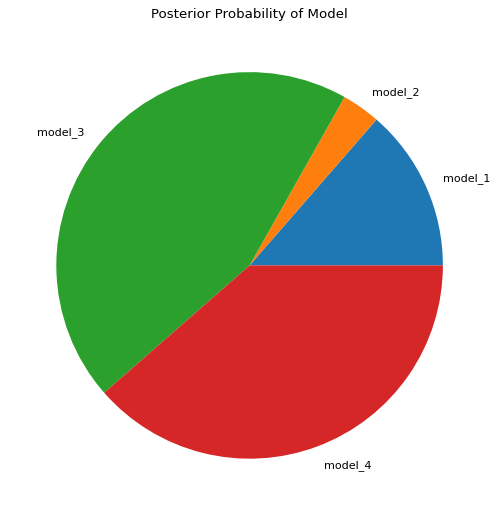

posterior_pro of model_1 is 0.13601346502691797
posterior_pro of model_2 is 0.032242341951943136
posterior_pro of model_3 is 0.4462279195909757
posterior_pro of model_4 is 0.3855162734301632
None


In [217]:
inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}

in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)

llh1 = likelihood_calculation(in_exp, out_exp, inf_theta1, func1, count_theta = 600, count_weight = 200).likelihood()
llh2 = likelihood_calculation(in_exp, out_exp, inf_theta2, func2, count_theta = 600, count_weight = 200).likelihood()
llh3 = likelihood_calculation(in_exp, out_exp, inf_theta3, func3, count_theta = 600, count_weight = 200).likelihood()
llh4 = likelihood_calculation(in_exp, out_exp, inf_theta4, func4, count_theta = 600, count_weight = 200).likelihood()
post = posterior_calculation(llh1, llh2, llh3, llh4)
print(post)


In [210]:
inf_theta1 = {'theta_0': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'theta_1': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_theta2 = {'theta_0': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'theta_1': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_theta3 = {'theta_0': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'theta_1': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'theta_2': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_theta4 = {'theta_0': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'theta_1': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'theta_2': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
inf_theta = [inf_theta1, inf_theta2, inf_theta3, inf_theta4]
model_set = [func1, func2, func3, func4]
in_exp = np.array([1,7,14,21,28,90,180,270,360]).reshape(-1, 1)
out_exp = np.array([0.259,0.544,0.639,0.727,0.796,1.054,1.189,1.297,1.410]).reshape(-1,1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

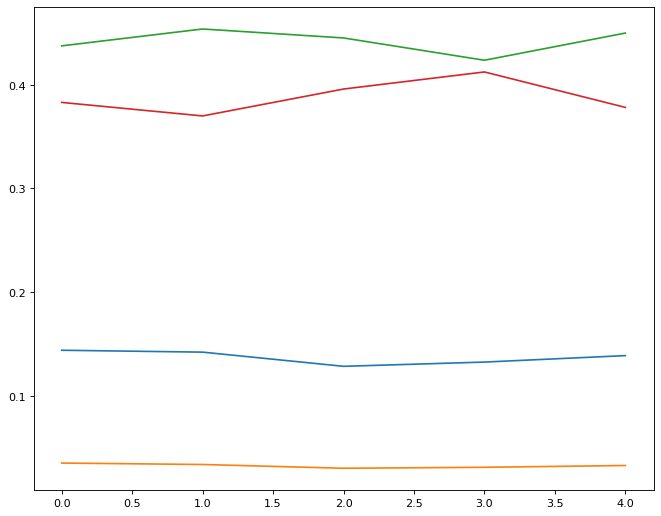

In [216]:
pp = Assessment_of_convergence(in_exp, out_exp, inf_theta, model_set, 5, 100, 100)

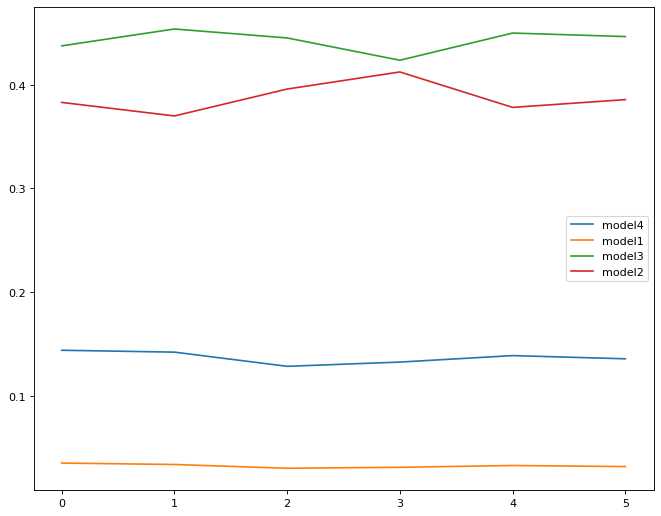

In [233]:
pp_m1 = np.array([0.14424044, 0.1424203, 0.12877065, 0.1328521, 0.13907822, 0.13601346502691797])
pp_m2 = np.array([0.03563411, 0.03424991, 0.0306272 , 0.031561  , 0.03327991, 0.032242341951943136])
pp_m3 = np.array([0.43728903, 0.45352207, 0.44489497, 0.42342699, 0.44960288, 0.4462279195909757])
pp_m4 = np.array([0.38283642, 0.36980772, 0.39570718, 0.41215991, 0.37803898, 0.3855162734301632])
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(pp_m1)
plt.plot(pp_m2)
plt.plot(pp_m3)
plt.plot(pp_m4)
plt.legend({'model1', 'model2','model3', 'model4'})
plt.show()